In [3]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import datetime as dt

import wbdata
# we hates modules that don't apppear on anaconda!
# pip install wbdata
import datetime
import csv
import statsmodels.api as sm
from statsmodels.api import add_constant

# from pandas.stats.plm import PanelOLS
# deprecated

from linearmodels import PanelOLS
# pip install linearmodels

In [6]:
# https://github.com/xtophercook/jupyter/blob/master/us_fdiflowsstock_29777289490548.xls

import os
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )
    
Legatum_folder = BES_data_folder + os.sep + "Legatum" + os.sep
encoding = "ISO-8859-1"

In [7]:
## pull in and clean fdi stock data ##

# fdi = pd.read_excel("us_fdiflowsstock_29777289490548.xls", header = 4)
# save as csv! xls is a pain
# header=4 -> header=5



fdi_raw = pd.read_csv(Legatum_folder+"us_fdiflowsstock_29777289490548.csv", header=5, encoding=encoding)
fdi = fdi_raw.iloc[1:]
fdi = fdi_raw.transpose()

fdi.columns = fdi.iloc[0]
fdi = fdi.iloc[1:]
fdi = fdi.stack()
fdi = fdi.reset_index()

fdi.columns = ['Year', 'country', 'FDI stock']
fdi['Year'] = fdi['Year'].astype('int', errors='raise')
fdi['date'] = pd.to_datetime(fdi['Year'], errors='ignore', format = "%Y")
fdi['FDI stock'] = pd.to_numeric(fdi['FDI stock'], errors='coerce')
fdi['country'] = fdi['country'].str.strip()
##### sort -> sort_values
fdi = fdi.sort_values(["country", "date"])

## pull year from annual data to ease matching to rest ## 
fdi['year'] = pd.DatetimeIndex(fdi['date']).year
fdi = fdi.set_index(["country", "year"])
del fdi['Year']
del fdi['date']

## pull remaining data from the world bank ##

indicators = {"ny.gdp.pcap.cd" : "GDP per capita", "SH.XPD.CHEX.PC.CD": "Health expenditure", "FS.AST.PRVT.GD.ZS" : "Domestic credit", "TX.VAL.FUEL.ZS.UN" : "Fuel exports", "TX.VAL.MMTL.ZS.UN" : "Ore and metal", "se.prm.cmpt.zs" : "Primary school completion", "sp.pop.totl" : "Population"}
df = wbdata.get_dataframe(indicators, country="all", data_date=(datetime.datetime(2010, 1, 1), datetime.datetime(2018, 1, 1)),  convert_date=True)

## pull year from annual data to ease matching to fdi ## 
df = df.reset_index()
df['year'] = pd.DatetimeIndex(df['date']).year
df = df.set_index(["country", "year"])
del df['date']

df = df.join(fdi)
df = df.dropna()

df['FDI stock per capita'] = df['FDI stock']/df['Population']
df['GDP per capita log'] = df['GDP per capita'].apply(np.log)
df['FDI log'] = df['FDI stock per capita'].apply(np.log)

## this caps the number of obs per country at 4 - gives you 379 rows (their n = 384)##

df = df.reset_index()
#df_2 = df.groupby("country").head(4)
#df = df_2
df = df.set_index(["year", "country"])


# indicators = {"BN.KLT.DINV.CD" : "FDI", "NY.GDP.MKTP.CD" : "GDP per capita", "SH.XPD.CHEX.PC.CD": "Health expenditure", "FS.AST.PRVT.GD.ZS" : "Domestic credit", "TX.VAL.FUEL.ZS.UN" : "Fuel exports", "TX.VAL.MMTL.ZS.UN" : "Ore and metal", "se.prm.cmpt.zs": "Primary school completion"}
# df = wbdata.get_dataframe(indicators, country="all", data_date=(datetime.datetime(2010, 1, 1), datetime.datetime(2018, 1, 1)),  convert_date=True)

# ## pull year from annual data to ease matching to fdi ## 
# df = df.reset_index()
# df['year'] = pd.DatetimeIndex(df['date']).year
# df = df.set_index(["country", "year"])
# del df['date']

# df = df.join(fdi)
# df = df.dropna()

# df['GDP per capita log'] = df['GDP per capita'].apply(np.log)
# df['FDI log'] = df['FDI stock'].apply(np.log)

# ## this caps the number of obs per country at 4 - gives you 379 rows (their n = 384)##

# df = df.reset_index()
# # df_2 = df.groupby("country").head(4)
# # df = df_2
# df = df.set_index(["country", "year"])




In [8]:
df
# passes eyeball comparison with xtophercooks notebook

,,GDP per capita,Health expenditure,Domestic credit,Fuel exports,Ore and metal,Primary school completion,Population,FDI stock,FDI stock per capita,GDP per capita log,FDI log
year,country,,,,,,,,,,,
2015,Albania,3952.830781,265.903236,37.151375,8.806638,7.545843,104.468193,2880703.0,4.336516e+03,0.001505,8.282187,-6.498718
2014,Albania,4578.666728,314.862629,39.261063,1.567523,4.582160,105.002121,2889104.0,4.295366e+03,0.001487,8.429163,-6.511165
2013,Albania,4413.081697,277.668927,39.787091,31.003052,9.783993,90.974411,2895092.0,3.930695e+03,0.001358,8.392329,-6.601956
2012,Albania,4247.614308,247.266691,40.803822,26.590781,10.912702,98.911697,2900401.0,4.303264e+03,0.001484,8.354113,-6.513230
2011,Albania,4437.178068,248.172587,41.153526,21.191947,11.903426,93.277008,2905195.0,4.399132e+03,0.001514,8.397774,-6.492849
2010,Albania,4094.358832,204.213137,39.083743,17.973227,12.829349,89.237343,2913021.0,3.254943e+03,0.001117,8.317365,-6.796771
2015,Algeria,4160.220067,291.635898,21.725470,94.325860,0.309081,105.436417,39871528.0,2.623229e+04,0.000658,8.333323,-7.326427
2014,Algeria,5466.425778,357.898943,18.351978,95.764232,0.179691,108.280853,39113313.0,2.681960e+04,0.000686,8.606380,-7.285085
2013,Algeria,5471.123389,330.223372,16.497891,96.722000,0.167012,105.913170,38338562.0,2.531287e+04,0.000660,8.607239,-7.322899


In [10]:
df = df.reset_index().set_index(['country','year'])

In [47]:
Y = df["GDP per capita log"]
X = df[["FDI log", "Health expenditure", "Domestic credit", "Fuel exports", "Ore and metal", "Primary school completion"]]
X = add_constant(X)

# regression=PanelOLS(y=Y, x=X, time_effects=True)
# regression

# linearmodel PanelOLS is *not completely identical* to pandas
# their explanation of the differences
# https://bashtage.github.io/linearmodels/doc/panel/pandas.html

PanelOLS(Y, X, time_effects=True).fit()

Dep. Variable:,GDP per capita log,R-squared:,0.8906
Estimator:,PanelOLS,R-squared (Between):,0.8904
No. Observations:,501,R-squared (Within):,-1.2387
Date:,"Thu, Sep 27 2018",R-squared (Overall):,0.8903
Time:,15:37:19,Log-likelihood,-344.05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,663.23
Entities:,115,P-value,0.0000
Avg Obs:,4.3565,Distribution:,"F(6,489)"
Min Obs:,1.0000,,
Max Obs:,6.0000,F-statistic (robust):,663.23


In [12]:
PanelOLS(Y, X, time_effects=True, entity_effects=True).fit()

Dep. Variable:,GDP per capita log,R-squared:,0.2539
Estimator:,PanelOLS,R-squared (Between):,0.4144
No. Observations:,501,R-squared (Within):,0.3414
Date:,"Thu, Sep 27 2018",R-squared (Overall):,0.4318
Time:,13:58:58,Log-likelihood,695.50
Cov. Estimator:,Unadjusted,,
,,F-statistic:,21.272
Entities:,115,P-value,0.0000
Avg Obs:,4.3565,Distribution:,"F(6,375)"
Min Obs:,1.0000,,
Max Obs:,6.0000,F-statistic (robust):,21.272


In [ ]:
############## this model makes no sense to me
### try a dump tree based regression

In [21]:
df_flat = df.reset_index()
Y = df_flat["GDP per capita log"]
X = df_flat[["FDI log", "Health expenditure", "Domestic credit", "Fuel exports", "Ore and metal", "Primary school completion"]]
X = add_constant(X)

In [31]:
train = X
target = Y

In [29]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [30]:
alg = XGBRegressor(
 learning_rate =0.04,
 n_estimators= 20,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.9,
 colsample_bylevel=.85,
 objective= 'reg:linear',
 scale_pos_weight=1.0,
 reg_alpha=0,
 reg_lambda=1,
 njobs=3,
 seed=27)

In [34]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=test_size,
                                                    random_state=seed, stratify = round(target*2))



eval_set = [(X_test, y_test)]

alg.fit(X_train, y_train, eval_metric='rmse', 
        early_stopping_rounds=alg.get_params()['n_estimators']*.1, eval_set=eval_set,
        verbose=True)

[0]	validation_0-rmse:8.05943
Will train until validation_0-rmse hasn't improved in 2.0 rounds.
[1]	validation_0-rmse:7.74112
[2]	validation_0-rmse:7.44017
[3]	validation_0-rmse:7.14756
[4]	validation_0-rmse:6.86607
[5]	validation_0-rmse:6.59424
[6]	validation_0-rmse:6.33842
[7]	validation_0-rmse:6.09239
[8]	validation_0-rmse:5.85592
[9]	validation_0-rmse:5.62505
[10]	validation_0-rmse:5.40665
[11]	validation_0-rmse:5.1948
[12]	validation_0-rmse:4.99072
[13]	validation_0-rmse:4.7947
[14]	validation_0-rmse:4.60733
[15]	validation_0-rmse:4.42761
[16]	validation_0-rmse:4.25343
[17]	validation_0-rmse:4.08962
[18]	validation_0-rmse:3.93134
[19]	validation_0-rmse:3.77967


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.85,
       colsample_bytree=0.9, gamma=0, learning_rate=0.04, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, njobs=3, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=27, silent=True, subsample=0.75)

In [35]:
# make predictions for test data
predictions = alg.predict(X_test)

# evaluate predictions
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
EV = explained_variance_score(y_test, predictions)
R2 = r2_score(y_test, predictions)

print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
alg.set_params(n_estimators=alg.best_iteration)

####################################
# fit to full dataset at non-overfitting level
alg.fit(train, target, verbose=True)

MSE: 14.29, MAE: 3.69, EV: 0.70, R2: -5.73


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.85,
       colsample_bytree=0.9, gamma=0, learning_rate=0.04, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=19,
       n_jobs=1, njobs=3, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0,
       seed=27, silent=True, subsample=0.75)

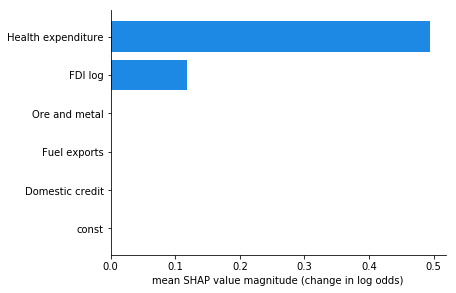

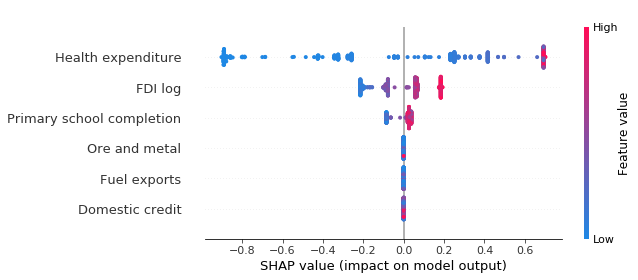

In [42]:
shap_values = shap.TreeExplainer(alg).shap_values(train);


#################################
threshold = .1
min_features = 6
global_shap_vals = np.abs(shap_values).mean(0)[:-1]
n_top_features = sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold)
if n_top_features <min_features:
    n_top_features = min_features



##########################

inds = np.argsort(global_shap_vals)[-n_top_features:]

y_pos = np.arange(n_top_features)
plt.figure(figsize=(16,10))
plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
plt.yticks(y_pos, train.columns[inds])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel("mean SHAP value magnitude (change in log odds)")
plt.gcf().set_size_inches(6, 4.5)

# plt.savefig(output_subfolder + "mean_impact" + ".png", bbox_inches='tight')

plt.show()

####################
fig = plt.figure()
shap.summary_plot(shap_values, train, max_display=n_top_features, plot_type='dot');
# fig.savefig(output_subfolder + "summary_plot" + ".png", bbox_inches='tight')


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


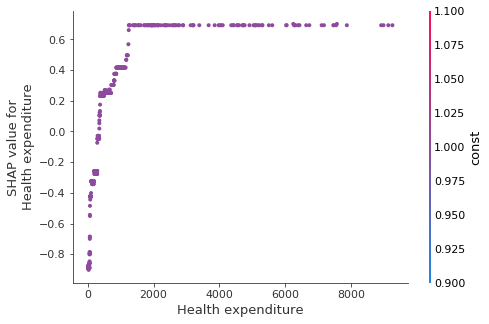

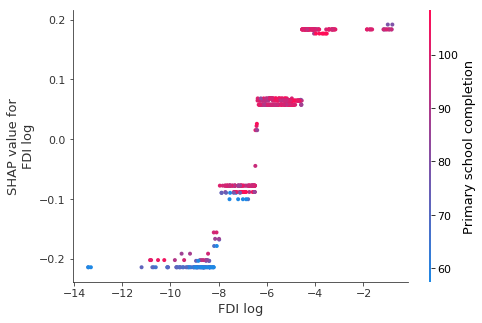

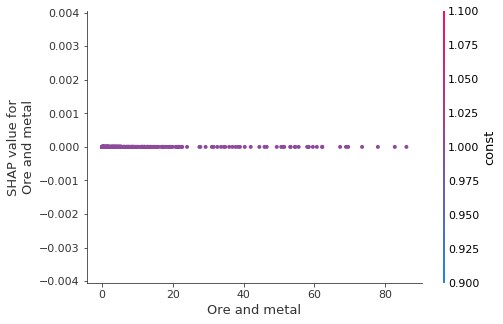

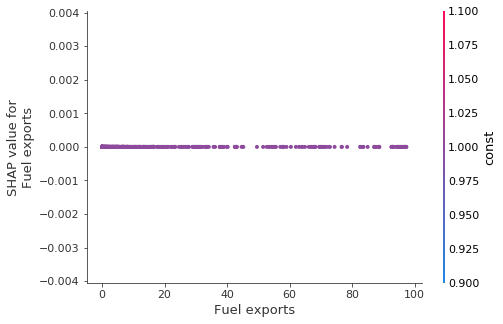

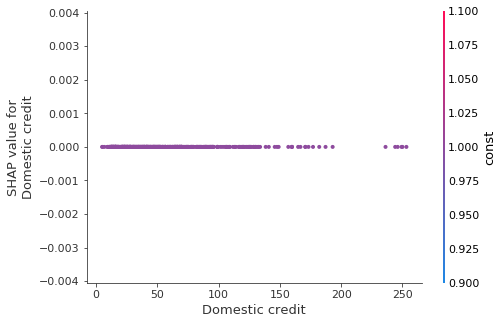

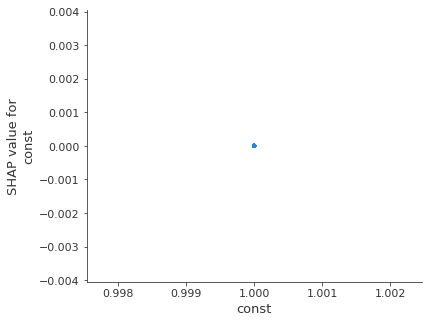

In [43]:
count = 0
for name in train.columns[inds[::-1]]:
    fig = plt.figure(figsize = (16,10))    
    shap.dependence_plot(name, shap_values, train)
#     fig.savefig(output_subfolder + "featureNo "+str(count) + " " + name.replace("/","_")[0:30] + ".png", bbox_inches='tight')
    count = count + 1